In [1]:
#Load all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle
import joblib
import gzip

In [2]:
#Set some global plot defaults
sns.set(rc={"figure.figsize": (10, 5), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes',  labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes',  titlesize=18)                                  # fontsize of the title

In [3]:
#Utility function to calculate pvalues of input df
def calculate_pvalues(df, func=stats.pearsonr):
    
    #Process the df
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    
    #Get the p-values for each combination of columns
    for r in df.columns:
        for c in df.columns:
            if r == c:
                pvalues[r][c] = np.nan
            else:
                pvalues[r][c] = round(func(df[r], df[c])[1], 160)
                
    #Make sure the output is numeric            
    pvalues = pvalues.apply(pd.to_numeric)   
    
    #Modify the p-values to take the multiple comparisons problem in account
    return pvalues*(len(pvalues)*(len(pvalues)-1)/2)

------------------------

We start by loading in our fully clean and wrangled dataset from the previous notebook.

In [4]:
with gzip.GzipFile('data/cleaned_df.pkl.gz', 'r') as file:  
    df = joblib.load(file)
    
df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546126 entries, 0 to 546125
Data columns (total 24 columns):
Date                    546126 non-null datetime64[ns]
Category                546126 non-null object
Supervisor_District     546126 non-null float64
Police_District         546126 non-null object
Latitude                546126 non-null float64
Longitude               546126 non-null float64
Source                  546126 non-null object
Has_Media_Link          546126 non-null bool
Tract                   546126 non-null float64
Poverty                 546126 non-null float64
Income                  546126 non-null float64
Unemployment            546126 non-null float64
Population              546126 non-null float64
Percent_Male            546126 non-null float64
Percent_Pop_0_14        546126 non-null float64
Percent_Pop_15_24       546126 non-null float64
Percent_Pop_25_64       546126 non-null float64
Percent_Pop_65_up       546126 non-null float64
Percent_Pop_White       

Because this dataset is a time series problem, let's see how it is distributed through time. We can start with years first. The table below is the count of requests over the years, in this case 2015-2017.

In [5]:
df.Date.dt.year.value_counts().sort_values().to_frame()

,Date
2015,131522
2016,186867
2017,227737


We can see there is an increasing trend. Is there a dependence on the month of the year? 

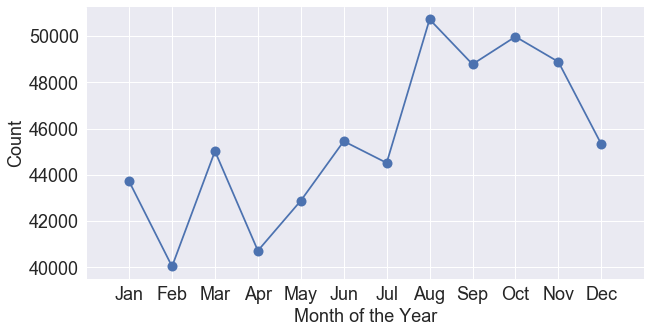

In [6]:
df.Date.dt.month.value_counts().sort_index().plot(style='.-', markersize=20)
plt.xticks(range(14), ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''], 
           rotation=0)
plt.xlabel('Month of the Year')
plt.ylabel('Count')
plt.show()

It is interesting to see that there is quite a bit of variation given any particular month. It is clear the back half of the year gets more requests, though it is not clear why. Perhaps there are PR campaigns for the 311 service during that time frame? At this point we can only speculate.

Is there a variation given the day of the month?

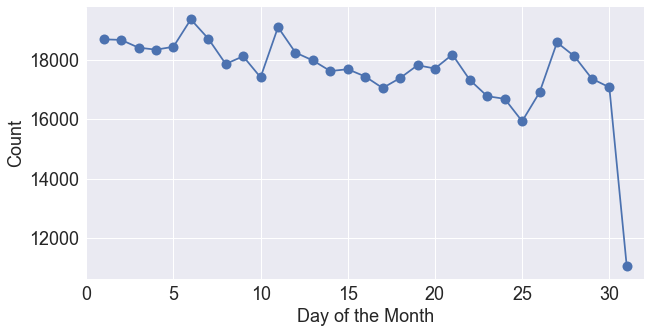

In [7]:
df.Date.dt.day.value_counts().sort_index().plot(style='.-', markersize=20.)
plt.xlim([0,32])
plt.xticks(rotation=0)
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.show()

This seems relatively consistent (except the 31st, of course) over all days. This is naively what we probably should expect, given that this is, essentially, averaged over 12 months across 3 years. We can make the same plot for the day of the week as well. It is easiest to build this plot by first extracting a categorical version of the day of the week.

In [8]:
#Get categorical day of the week
df['Day'] = pd.Categorical(df.Date.dt.weekday_name, ordered=True, 
                           categories=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

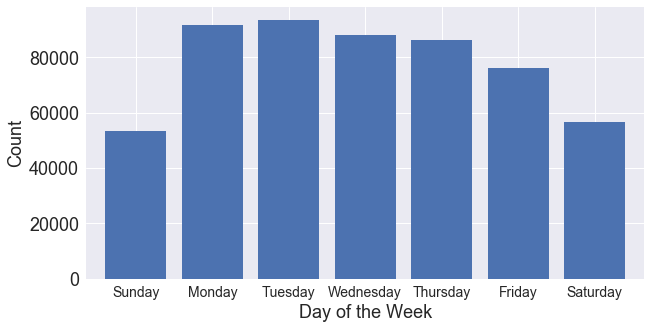

In [9]:
df.Day.value_counts().sort_index().plot(kind='bar', width=0.8)
plt.xticks(rotation=0, fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()

This distribution also seems to make sense. There are less requests on the weekend, but is pretty constant on both weekends and week days, respectively. 

Next, we can see how the different **categories** are distributed throughout the three years in the data. Here we upsample the requests to the order of weeks (from seconds) and count the requests. We can do this easily by first creating a new dataframe, ts, to keep only the **categories** and **date**. Then we resample per week and count the requests for each **category** during that time frame. Then we can plot this weekly count data as a time series.  

In [10]:
#Make new dataframe
ts = df.copy()
ts = ts[['Date', 'Category']]
ts.set_index('Date', inplace=True)
ts = pd.get_dummies(ts['Category'])

weekly_count = ts.resample('W').sum()

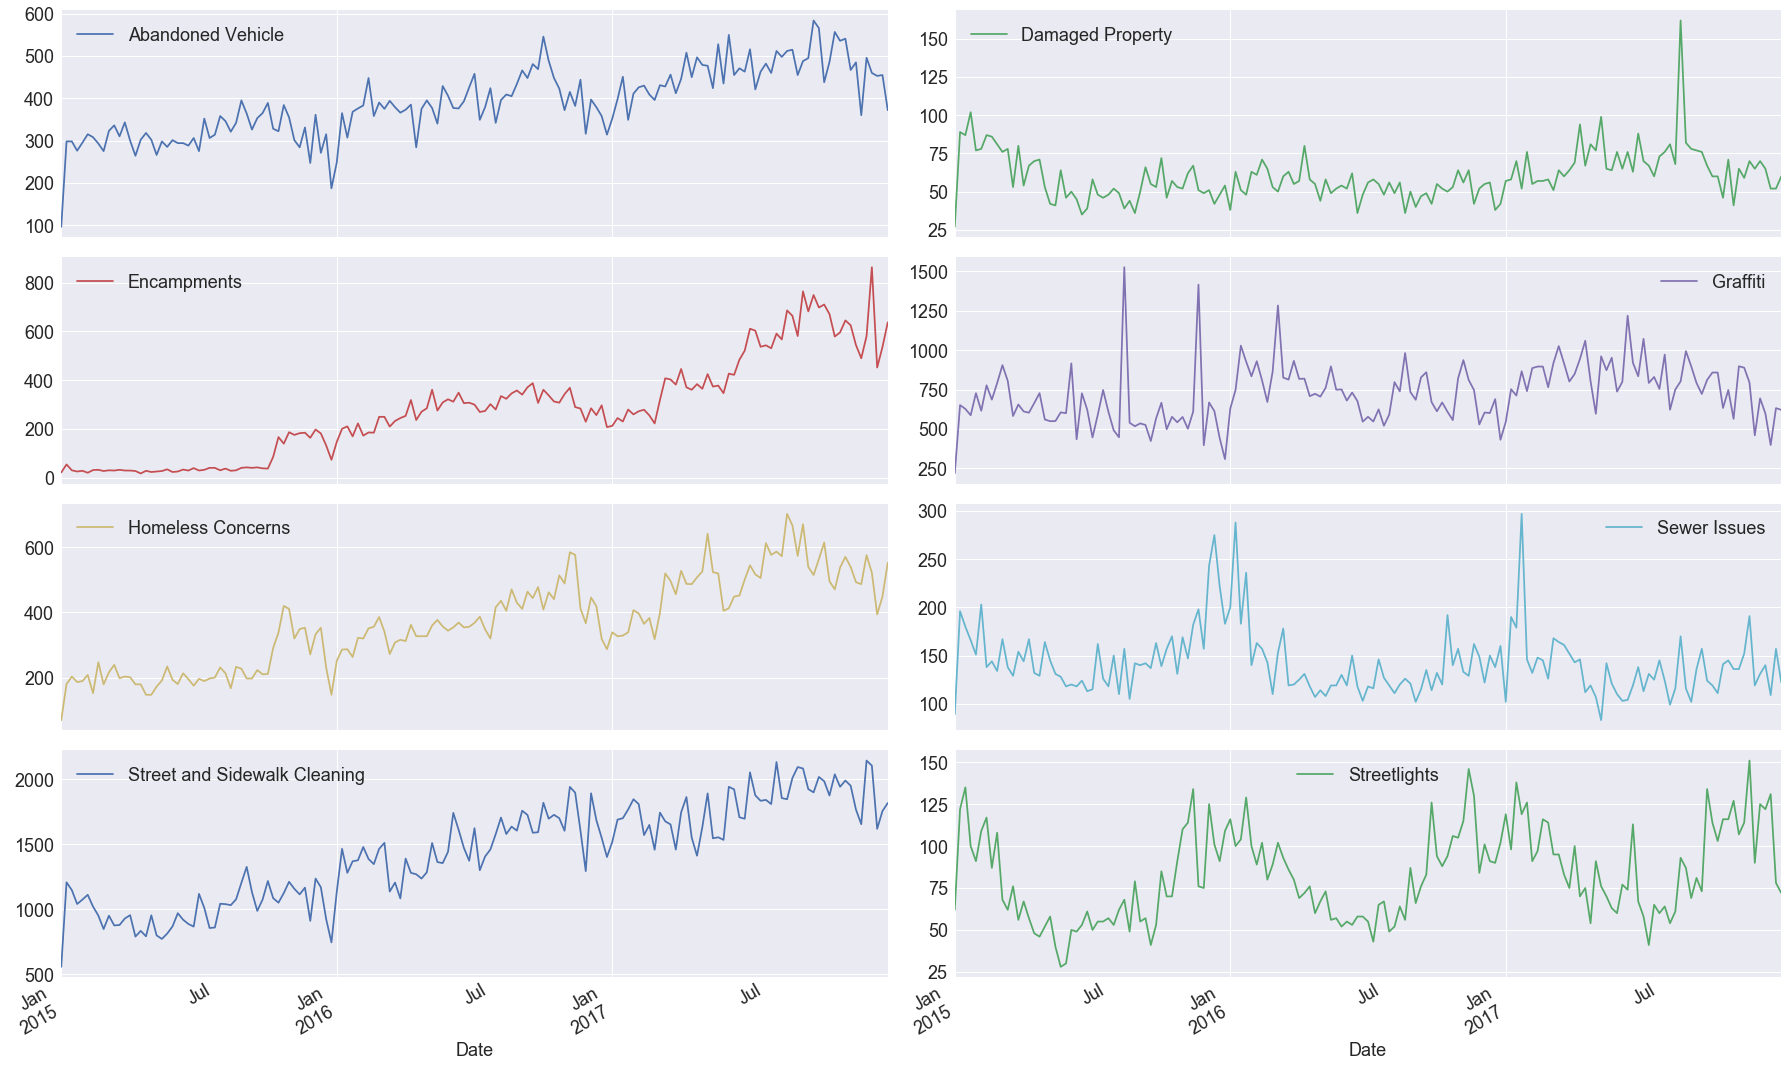

In [11]:
#Plot it
weekly_count.plot(subplots=True, figsize=(25, 15), layout=(4, 2), sharey=False)
plt.tight_layout()
plt.show()

So we see how the eight **categories** have had requests over the past few years. Its interesting to see the large uptick in requests about Encampments starting in late 2015. We can guess that coupled with the overall upward trend in Homeless Concerns, San Francisco is actively looking into this problem. We can also see an obvious seasonal pattern in Streetlight requests. 

We can also look at how the eight **categories** are related to each other. This can be easily achieved with a pair plot, which is shown below. 

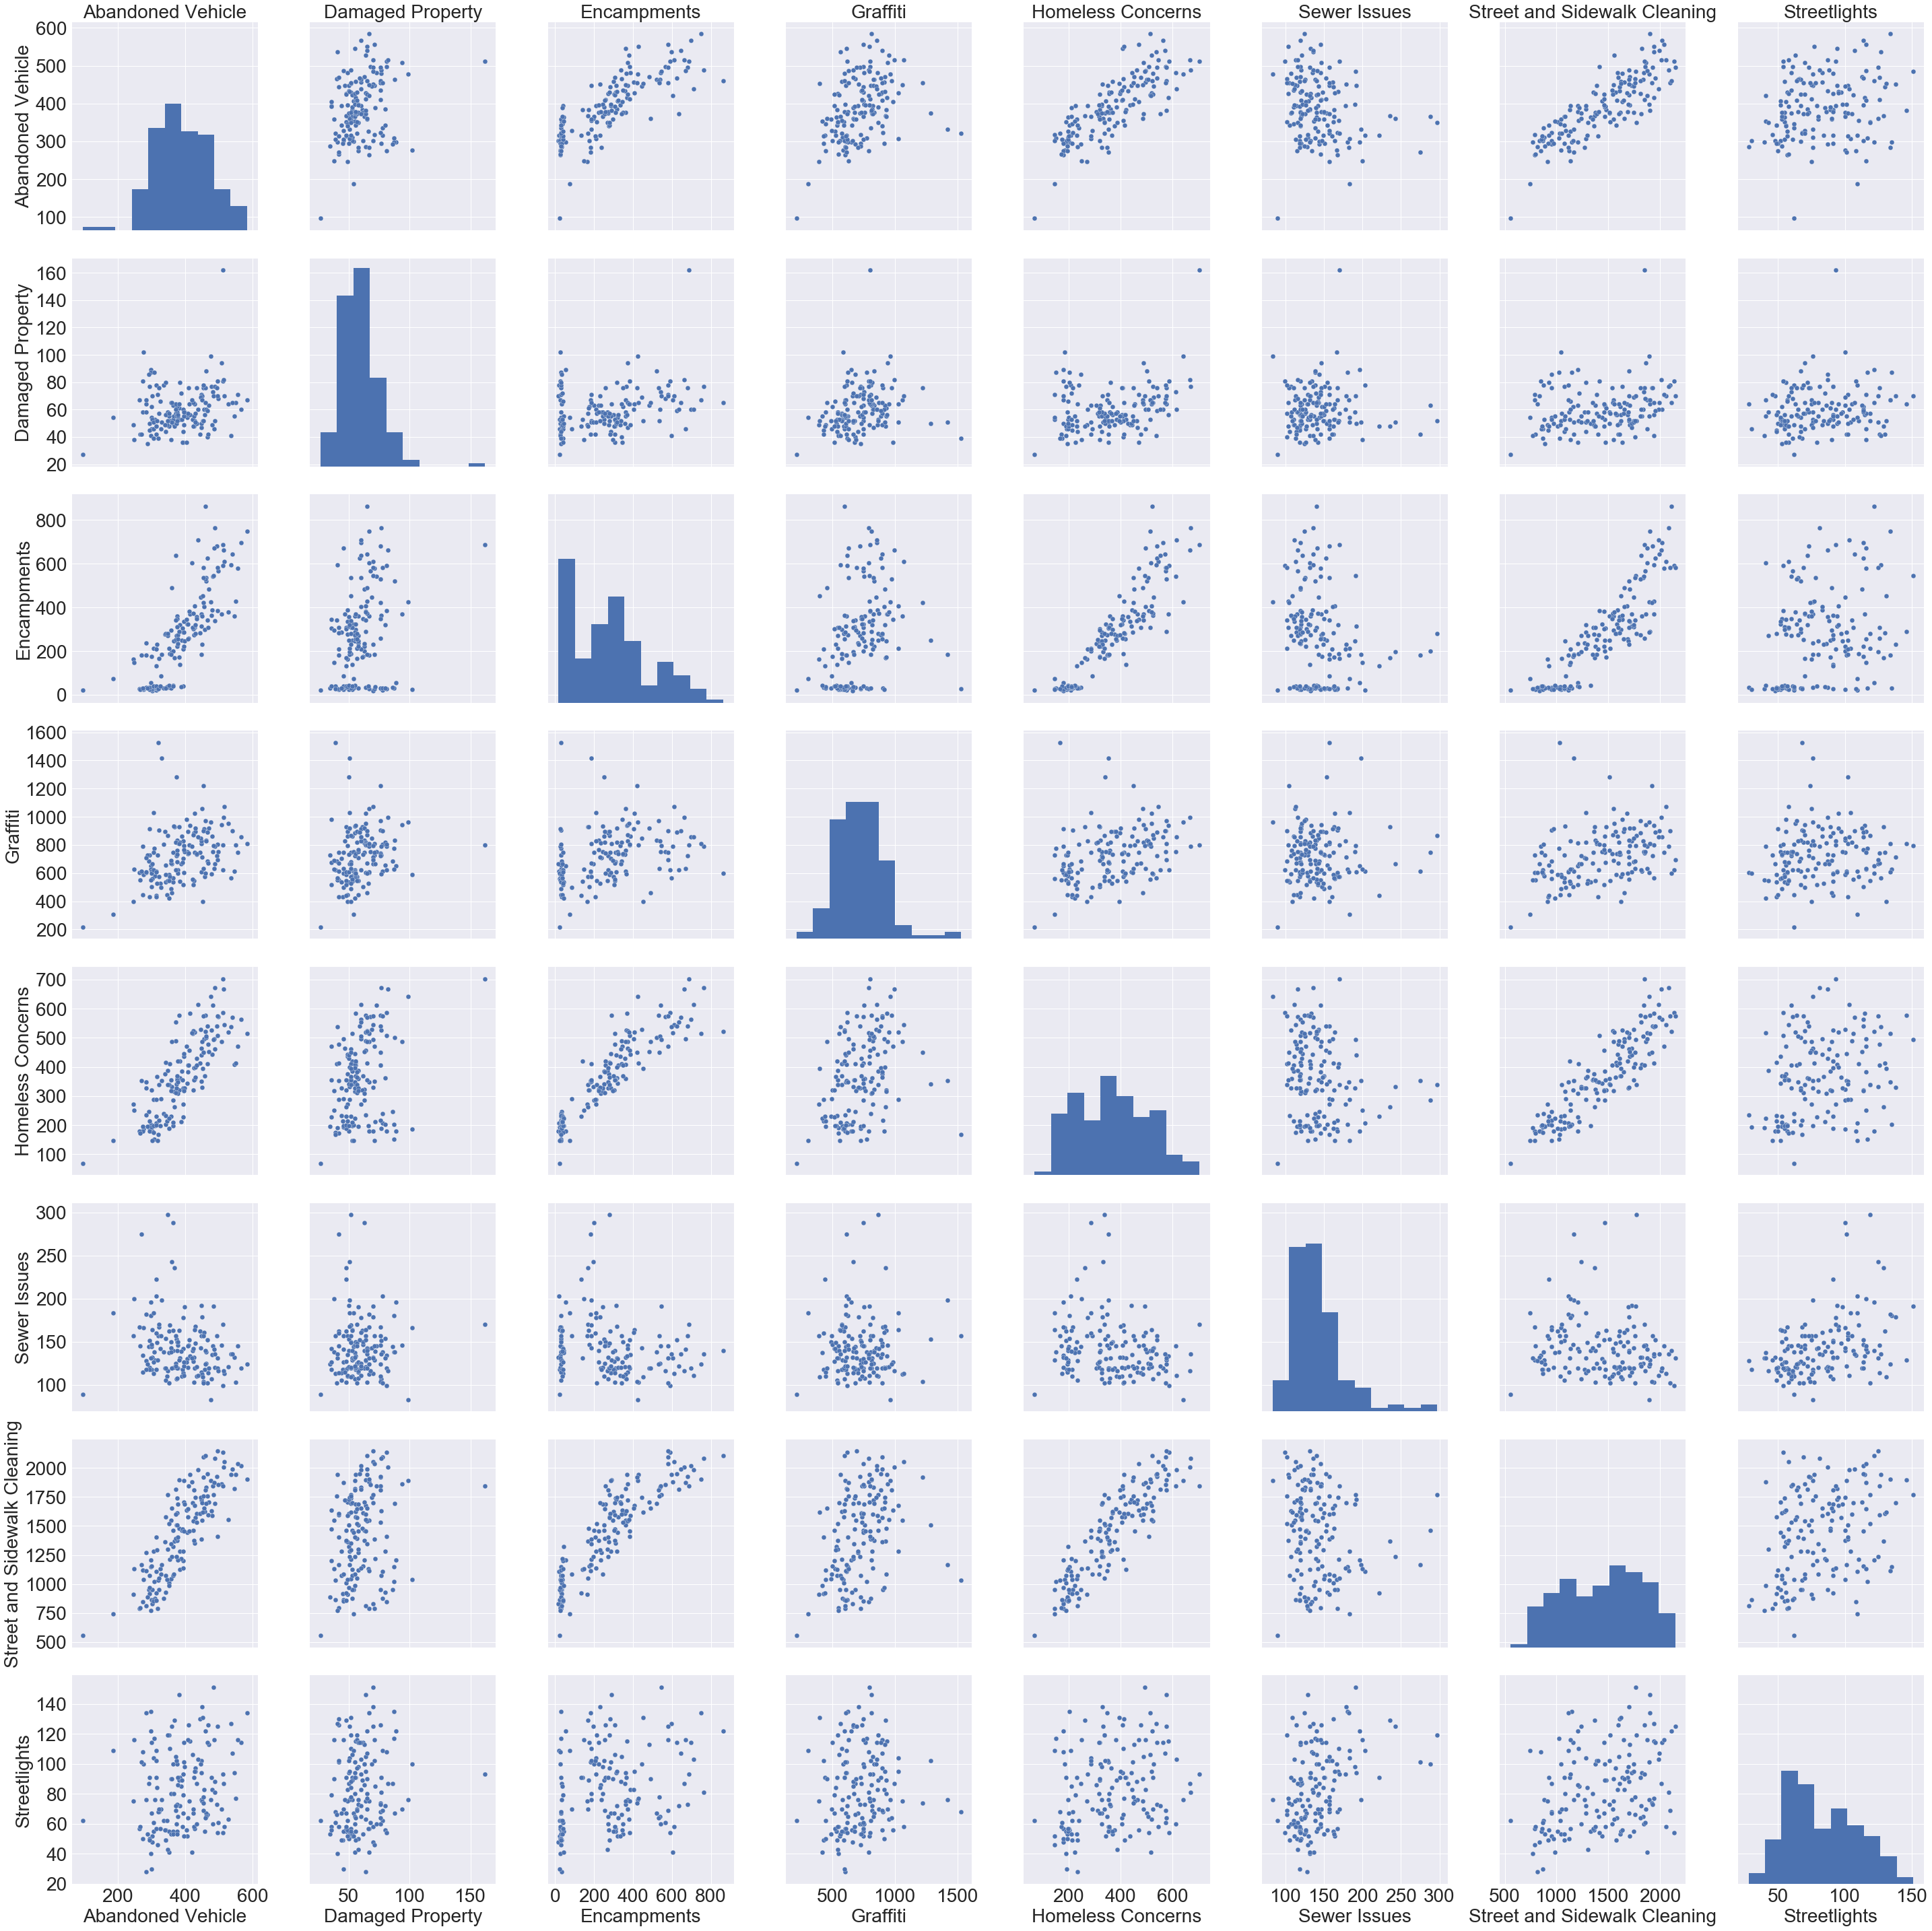

In [12]:
p = sns.pairplot(weekly_count.reset_index().drop('Date', axis=1), size=5)

#Cycle through each (sub)plot and adjust fontsize/title/label/tick label
num_cols = len(weekly_count.reset_index().drop('Date', axis=1).columns)
for i in range(0, num_cols):
    for j in range(0, num_cols): 
        #Make fontsize bigger for axis labels
        p.axes[j,i].set_xlabel(p.axes[j,i].get_xlabel(), fontsize=28) 
        p.axes[j,i].set_ylabel(p.axes[j,i].get_ylabel(), fontsize=28) 
        
        #Remove tick labels or make fontsize bigger for tick labels for both axes
        if i != 0:
            plt.setp(p.axes[j,i].get_yticklabels(), visible=False)
        else:
            plt.setp(p.axes[j,i].get_yticklabels(), fontsize='28')
        if j != num_cols-1:
            plt.setp(p.axes[j,i].get_xticklabels(), visible=False)
        else:
            plt.setp(p.axes[j,i].get_xticklabels(), fontsize='28')
            p.axes[0,i].set_title(p.axes[j,i].get_xlabel(), visible=True, fontsize=28)
                        
plt.tight_layout()
plt.show()

We can see some of these **categories** are show clear trends while others not as much. Some of these are obvious like Abandoned Vehicle and Street and Sidewalk Cleaning. However, we can quantify these trends by calculating the correlations. 

We can construct a heatmap showing the (Pearson) correlations. This (triangular) heatmap is shown below. 

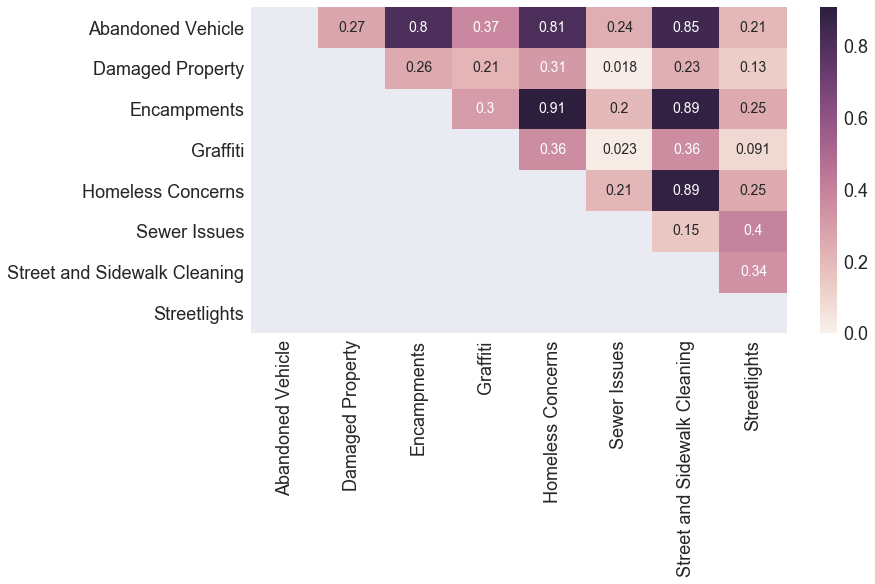

In [13]:
corr_mat = np.abs(weekly_count.corr(method='pearson'))
corr_mat_tri = np.triu(corr_mat, k=1)
corr_columns = list(corr_mat.columns)

plt.figure(figsize=(12,6))
sns.heatmap(corr_mat_tri, annot=True, mask=corr_mat_tri==0, annot_kws={'size': 14}, 
            xticklabels=corr_columns, yticklabels=corr_columns)
plt.show()

We can see there are indeed relatively large correlations between some of these eight **categories**. How significant are these though? Let's calculate the $p$-values for these correlations and plot the results in the same way. However, we must be very careful here. We are determining many correlations and their $p$-values at the same time. By chance, any one of these comparisons can be very small (i.e. $p <$ 0.05) potentially indicating significance where there might not actually be. This is known as the multiple comparisons problem (or the [look-elsewhere effect](https://en.wikipedia.org/wiki/Look-elsewhere_effect) in physics) and needs to addressed. The simplest, and most conservative, correction is to divide the threshold, or $\alpha$ level, by the number of comparisons made. In this case there are 28 comparisons ($\frac{8*7}{2}$), so we will need to adjust with this number. For visual purposes, we will actually multiply the $p$-values by 28, so that we can keep the usual 0.05 threshold. The effect is the exact same though. 

In this plot the z-axis (or color bar) has an upper limit of 0.05 to show which correlations might be significant at an $\alpha$=0.05 level. Note also that a lighter color indicates a small (adjusted) $p$-value. 

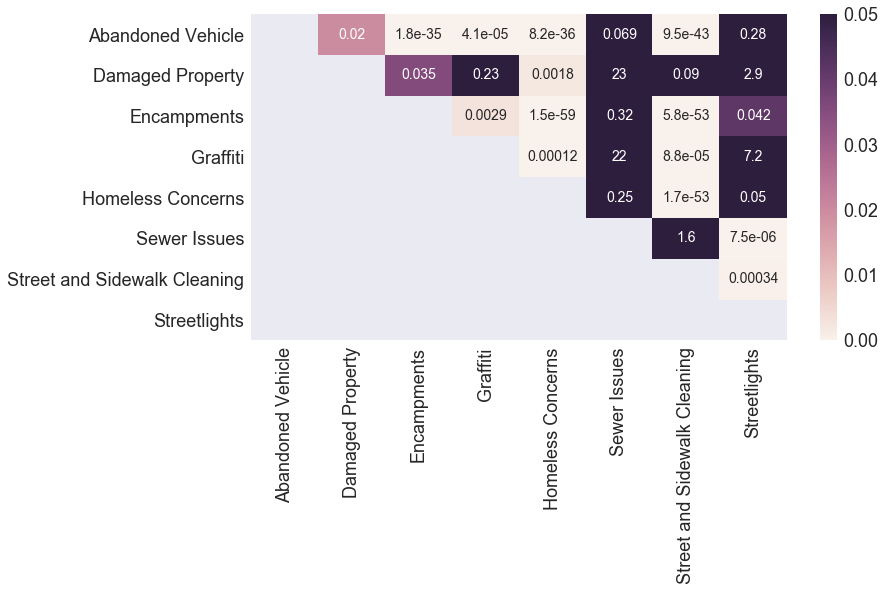

In [14]:
corr_pvalues = calculate_pvalues(weekly_count)
corr_pvalues_tri = np.triu(corr_pvalues, k=1)

plt.figure(figsize=(12,6))
sns.heatmap(corr_pvalues_tri, annot=True, mask = corr_pvalues_tri==0, xticklabels=corr_columns, 
            yticklabels=corr_columns, annot_kws={'size': 14}, vmax=0.05)
plt.show()

Even with our correction, we can see that some $p$-values are (very) small, indicating real significance and correlation between **categories**. In fact, over half show significance. This makes some sense as many of these **categories** do share similarities in the underlying issue. For example, we can probably expect real correlation between Encampments and Homeless Concerns. 

Switching gears a little, we can also look at some of the other features in the dataset. Recall we have information on the **police district** and **supervisor districts**. Do these districts have overlaps? We can make a cross-tabulation 
to figure out this overlap between these two. 

In [15]:
pd.crosstab(df['Police_District'], df['Supervisor_District'], dropna=False, margins=True)

Supervisor_District,-1.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,All
Police_District,,,,,,,,,,,,,
BAYVIEW,0,0,0,0,0,0,0,0,0,8464,33640,0,42104
CENTRAL,2,0,1543,53975,0,0,3250,0,0,0,0,0,58770
INGLESIDE,0,0,0,0,0,0,0,6351,8338,18099,5485,21264,59537
MISSION,0,0,0,0,0,0,435,0,38475,70699,11909,0,121518
NORTHERN,0,0,13825,6996,0,28596,3606,0,26,0,0,0,53049
PARK,0,1352,830,0,0,23945,0,2230,11134,0,0,0,39491
RICHMOND,0,33509,5657,0,0,292,0,0,0,0,0,0,39458
SOUTHERN,0,0,0,0,0,979,54581,0,1351,157,4032,0,61100
TARAVAL,0,0,0,0,20712,2638,0,11761,0,0,0,7091,42202


<br>

Its clear there is a lot of overlap between the two sets of districts. How do they actually overlap on official maps? We can take a look at these official maps, below. 

<br>

<center>Images of San Francisco's Police District (left panel) and Supervisor District (right panel).</center>
<figure class="half" style="display:flex">
     <img src="https://hoodwork-production.s3.amazonaws.com/uploads/story/image/10247/sfpdfinal.png" style="float: left; width: 50%; margin-right: 1%; margin-bottom: 0.5em;">
     <img src="https://localwiki.org/media/cache/ae/07/ae07016c0f6e55198ff1829a2cbb0933.png" style="float: right; width: 40%; margin-left: 1%; margin-bottom: 0.5em;">
</figure>

The official district maps show that overlap between the two districts quite plainly. So let's see these distriutions in our actual data. We can make a scatter plot for each district map. Both of these are created below.

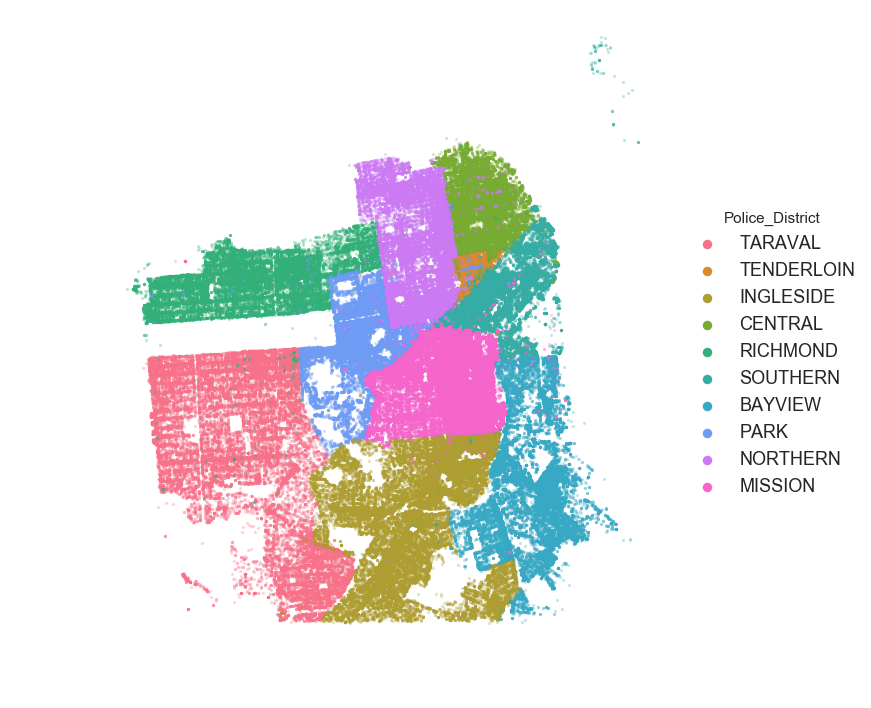

In [16]:
p = sns.lmplot(data=df, x='Longitude', y='Latitude', fit_reg=False, scatter_kws={'s': 10, 'alpha': 0.3}, 
               hue='Police_District', size=10, legend_out=True, legend=True)
for lh in p._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [90] 
plt.axis('off')
plt.show()

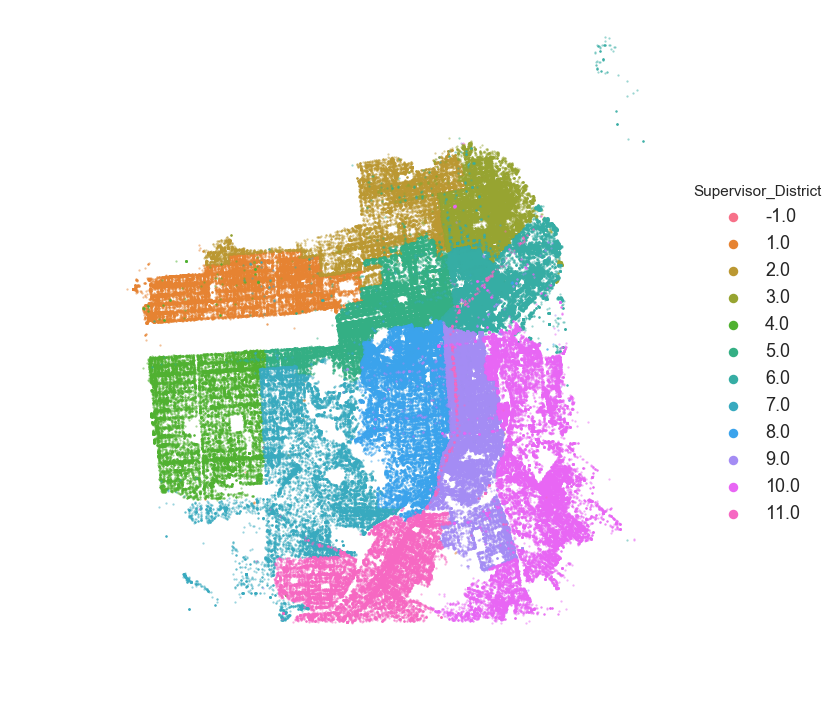

In [17]:
p = sns.lmplot(data=df, x='Longitude', y='Latitude', fit_reg=False, scatter_kws={'s': 5, 'alpha': 0.5}, 
               hue='Supervisor_District', size=10, legend_out=True, legend=True)
for lh in p._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [90] 
plt.axis('off')
plt.show()

By flipping between our scatter plots and the official district maps, we can see the data is representative of the district maps. However, in both we see there appear to be mis-classifications. For instance, there is a line of pink/fuschia going through the purple (District 9) patch. Those colors do not belong there given the official map. There are similar points throughout both maps. 

One additional thing we can check is how the request **categories** are distributed by **source**. In other words are there particular methods to make the request favored for certan? Like before we can make a cross-tabulation to see these results. 

In [18]:
pd.crosstab(df['Category'], df['Source'], dropna=False, margins=True)

Source,Email,Integrated Agency,Mobile/Open311,Other Department,Phone,Twitter,Web,All
Category,,,,,,,,
Abandoned Vehicle,0,0,10749,5,31037,31,19295,61117
Damaged Property,1,55,3674,1,4993,39,666,9429
Encampments,0,53,33513,3,5538,42,4503,43652
Graffiti,0,15580,75393,2,7955,260,14727,113917
Homeless Concerns,0,7,37681,4,13400,150,6408,57650
Sewer Issues,0,547,2782,5,16729,46,2182,22291
Street and Sidewalk Cleaning,0,9580,122868,11,71461,824,20336,225080
Streetlights,0,191,4768,1,5181,33,2816,12990
All,1,26013,291428,32,156294,1425,70933,546126


There does not appear to be anything standing out. The eight **categories** seem to not show any obvious dependence on the request **source**. We can also, like before, make a scatter plot according to location. However, after actually doing this the output is rather messy and difficult to meaningfully interpret. For this reason, these plots are omitted.

It is clear there are some strong correlations between some of the request **categories**. Naively this might be expected, but it is good to see a statistical argument for it. We also summarized the time aspect of the data to understand the distribution across different time scales. 

------------------

Et fin.